# LIMEを用いたMNIST画像分類

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.datasets import mnist

np.random.seed(1)
tf.random.set_seed(1)

print("tensorflow version : " + tf.__version__)

tensorflow version : 2.6.0


In [2]:
from skimage.color import gray2rgb

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_val = x_train[:5000]
x_train = x_train[5000:15000]
y_val = y_train[:5000]
y_train = y_train[5000:15000]

x_test = x_test[:5000]
y_test = y_test[:5000]

x_train = gray2rgb(x_train)
x_val = gray2rgb(x_val)
x_test = gray2rgb(x_test)

x_train = x_train.reshape((-1, 28, 28, 3))
x_train = x_train.astype('float64') / 255

x_val = x_val.reshape((-1, 28, 28, 3))
x_val = x_val.astype('float64') / 255

x_test = x_test.reshape((-1, 28, 28, 3))
x_test = x_test.astype('float64') / 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_val.shape: ', x_val.shape)
print('y_val.shape: ', y_val.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (10000, 28, 28, 3)
y_train.shape:  (10000, 10)
x_val.shape:  (5000, 28, 28, 3)
y_val.shape:  (5000, 10)
x_test.shape:  (5000, 28, 28, 3)
y_test.shape:  (5000, 10)


In [3]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(10, activation='softmax', name='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
softmax (Dense)              (None, 10)                27050     
Total params: 27,498
Trainable params: 27,498
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
79/79 [==============================] - 5s 60ms/step - loss: 0.8702 - accuracy: 0.7721 - val_loss: 0.3184 - val_accuracy: 0.9146
Epoch 2/5
79/79 [==============================] - 4s 55ms/step - loss: 0.2907 - accuracy: 0.9160 - val_loss: 0.2413 - val_accuracy: 0.9326
Epoch 3/5
79/79 [==============================] - 4s 56ms/step - loss: 0.2118 - accuracy: 0.9412 - val_loss: 0.1871 - val_accuracy: 0.9468
Epoch 4/5
79/79 [==============================] - 5s 59ms/step - loss: 0.1617 - accuracy: 0.9537 - val_loss: 0.1711 - val_accuracy: 0.9524
Epoch 5/5
79/79 [==============================] - 5s 58ms/step - loss: 0.1303 - accuracy: 0.9634 - val_loss: 0.1487 - val_accuracy: 0.9572


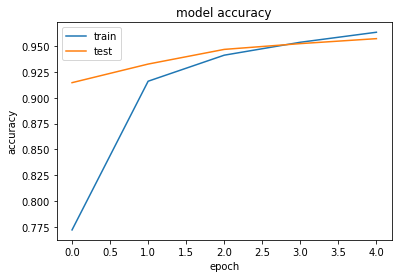

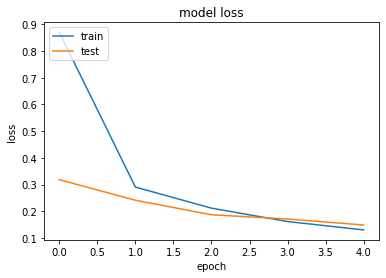

In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=128, epochs=5)

#正答率
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

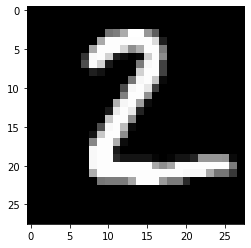

In [5]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

i = 1
plt.imshow(x_test[i])

In [6]:
df = pd.DataFrame(model.predict(x_test[i].reshape((1,28,28,3))), index=['result'])
df = df.transpose()
df = df.sort_values('result', ascending=False)
df

,result
2,9.740387e-01
0,1.554513e-02
1,3.761042e-03
6,2.859062e-03
5,2.585712e-03
3,7.498744e-04
8,4.601592e-04
9,2.318229e-07
4,1.231003e-09
7,6.573120e-10


  0%|          | 0/1000 [00:00<?, ?it/s]

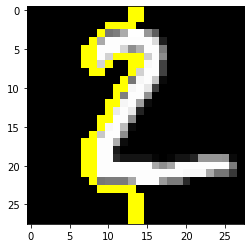

In [7]:
explainer = lime_image.LimeImageExplainer(random_state=42)
exp = explainer.explain_instance(
         x_test[i], 
         model.predict
)
image, mask = exp.get_image_and_mask(
         model.predict(
              x_test[i].reshape((1,28,28,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

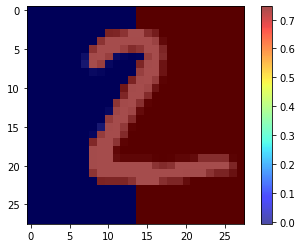

In [8]:
index = exp.top_labels[0]

dict_heatmap = dict(exp.local_exp[index])
heatmap = np.vectorize(dict_heatmap.get)(exp.segments)

plt.imshow(x_test[i])
plt.imshow(heatmap, alpha=0.7, cmap='jet')
plt.colorbar()